# Exercise 1

The submission deadline is **06.11.2023 23:55.**

## Task Description

The goal of this exercise is to model the relationship between weather observations and the occurence of traffic disruptions in the city of Vienna.

To investigate a potential relationship, we will use two datasets:
 * tri-daily weather reports from 2009 - 2021 of Vienna.
 * reports on traffic disruptions in Vienna ffrom 2013 - 2023.

In this exercise, you will 
 * use `pandas` to read, prepare and transform data,
 * use `matplotlib` to visually analyse data,
 * use `scikit-learn` to build prediction models.

The data to be used can be found in: `HOME/shared/188.995-2023W/data/`. 

To complete this exercise, you will have to:
* prepare the data, which (at minimum) involves the following:
    - load and prepare the data
    - handling missing values
    - handling outliers
    - temporal alignment of the two datasets
* analyse the data:
    - compare descriptive statistics
    - visually investigate the raw data to gain an understanding of the data identify patterns, outliers etc.,
    - look at the relationship between the variables of interest
* model the relationship:
    - fit a model that classifies new traffic disruptions from weather observation data
    
    
**Note:** In case you encounter problems with loading and processing the data (tasks 1-5), we will provide you also with a pickled version of a preprocessed and merged datasets that you can use to complete the remaining parts of the exercise (tasks 6-8).

There is a total of 100 points that can be reached which are distributed in two notebooks in the following way:

Notebook A (this notebook), total 55 points:
 - Task 1: 20 points
 - Task 2: 15 points
 - Task 3: 10 points
 - Task 4: 5 points
 - Task 5: 5 points


 Notebook B, total 45 points:
 - Task 6: 15 points
 - Task 7: 20 points
 - Task 8: 10 points

In [1]:
# DO NOT MODIFY OR COPY THIS CELL!! 
# Note: The only imports allowed are Python's standard library, pandas, numpy, scipy, matplotlib, seaborn and scikit-learn
import numpy as np
import pandas as pd
import glob
import os
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import pickle
import typing


## Task 1: Load Data (20 Points)

### 1.1: Weather observations

As a first step, implement the method `load_weather_data()`, which should read all individual (yearly) datasets from the csv files in `data/weather/` into a single `pd.DataFrame` and return it. 

- make sure that you load all the data (2009-2021, 13 years)
- split the tri-daily and daily data (tri-daily data has _7h, _14h, and _19h suffixes for column headers), and convert the tri-daily data from a wide to a long format (use pandas' [wide_to_long](https://pandas.pydata.org/docs/reference/api/pandas.wide_to_long.html) or [melt](https://pandas.pydata.org/docs/reference/api/pandas.melt.html#pandas.melt) functions). Introduce a new `hours` column which's values should be taken from the column suffixes.
- make sure all columns are appropriately typed (numeric values -> float, countables, i.e. days -> int, etc.)! Especially the `date` column! See datetime and [`pandas.Timestamp`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Timestamp.html)!
- from the `date` column create `year`, `month`, `day` columns. Use Pandas built-in datetime handling features.
- from the wide to long transform, you should have an `hour` column with the 7, 14, or 19 hours values.
- create a `MultiIndex` from the date columns with the following hierarchy: `year` - `month` - `day` - `hour` (make sure to label them accordingly)

**Hints:**
 
 - LOOK at the data in the original files
 - It is advisable not to append each data set individually, but to read each data frame, store it into a list and  combine them once at the end.
 - Note that for the `precip` data column you will get an unexpected (object) datatype. For this task it is ok to leave it like that, it is due to special values, see next chapters!
 - You will find similar names, in the disruption column, you are free to combine them to reduce the number of different disruptions.
 - Your resulting data frame should look as follows:
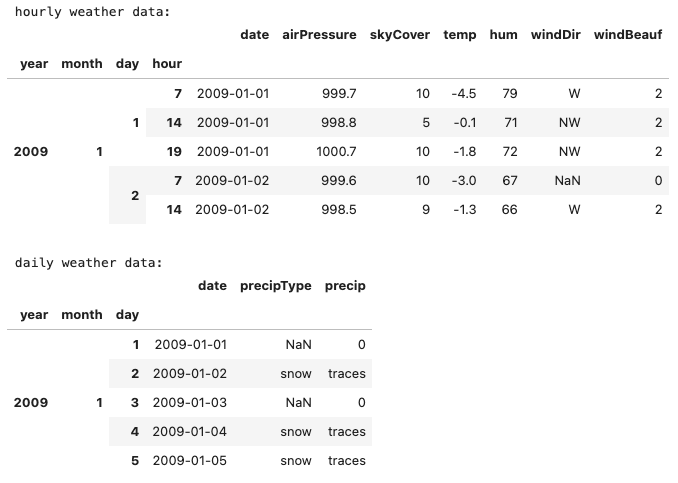

In [4]:
# DO NOT MODIFY OR COPY THIS CELL!! 
data_path = os.path.join(os.environ["HOME"], "shared", "188.995-2023W", "data")
weather_data_path = os.path.join(data_path, 'weather')
traffic_data_path = os.path.join(data_path, 'traffic')

In [5]:
def load_weather_data(weather_data_path:str) -> typing.Tuple[pd.DataFrame, pd.DataFrame]:
    """ 
    Load all weather data files and combine them into a single Pandas DataFrame.
    Split the tri-daily data from the daily data.
    For the tri-daily data create a new hour column using the indicated hour in the column names.
    Add a hierarchical index (year, month, day, hour).
    For the daily-only data also add a hierarchical index (year, month, day).
    
    Parameters
    --------
    weather_data_path: path to directory containing weather data CSV files
    
    Returns
    --------
    weather_data: data frame containing the tri-daily (hours) weather data
    weather_data_daily: data frame containing the daily weather data (e.g. precip, precipType, etc.)
    """

    # YOUR CODE HERE
    df_list = []
    for file_name in sorted(os.listdir(weather_data_path)):
        if file_name.endswith(".csv"):
            df_list.append(pd.read_csv(os.path.join(weather_data_path, file_name), sep=";"))
    
    joined_df = pd.concat(df_list)
    joined_df["date"] = pd.to_datetime(joined_df["date"], format="%d.%m.%Y")

    weather_data_daily = joined_df[["date", "precipType", "precip"]].copy()
    weather_data_daily["year"] = joined_df["date"].dt.year
    weather_data_daily["month"] = joined_df["date"].dt.month
    weather_data_daily["day"] = joined_df["date"].dt.day
    weather_data_daily.set_index(["year", "month", "day"], inplace=True)

    melt_columns = ["airPressure", "skyCover", "temp", "hum", "windDir", "windBeauf"]

    weather_data = None
    for col_name in melt_columns:
        to_join_df = pd.melt(joined_df, id_vars=["date"], value_vars=[f"{col_name}_7h", f"{col_name}_14h", f"{col_name}_19h"])
        to_join_df["variable"] = to_join_df["variable"].str.extract(r'(\d+)h', expand=False).astype(int)
        to_join_df.columns = ["date", "hour", col_name]
        date_series = to_join_df["date"].copy()
        to_join_df.set_index(["date", "hour"], inplace=True, drop=False)
        if weather_data is None:
            weather_data = to_join_df.drop(["hour"], axis=1)
        else:
            weather_data = weather_data.join(to_join_df.drop(["date", "hour"], axis=1))


    weather_data = weather_data.sort_index()

    # Extract the date and hour
    dates = weather_data.index.get_level_values("date")
    hours = weather_data.index.get_level_values("hour")

    # Create a new MultiIndex
    new_index = pd.MultiIndex.from_arrays([
        dates.year,
        dates.month,
        dates.day,
        hours
    ], names=["year", "month", "day", "hour"])
    weather_data.index = new_index

    return weather_data, weather_data_daily

In [6]:
# DO NOT MODIFY OR COPY THIS CELL!! 
weather_data, daily_weather_data = load_weather_data(weather_data_path)
# print first couple of rows:
print('hourly weather data:')
display(weather_data.head())
print('\ndaily weather data:')
display(daily_weather_data.head())

hourly weather data:


date  airPressure  skyCover  temp  hum windDir  \
year month day hour                                                        
2009 1     1   7    2009-01-01        999.7        10  -4.5   79       W   
               14   2009-01-01        998.8         5  -0.1   71      NW   
               19   2009-01-01       1000.7        10  -1.8   72      NW   
           2   7    2009-01-02        999.6        10  -3.0   67     NaN   
               14   2009-01-02        998.5         9  -1.3   66       W   

                     windBeauf  
year month day hour             
2009 1     1   7             2  
               14            2  
               19            2  
           2   7             0  
               14            2


daily weather data:


date precipType  precip
year month day                              
2009 1     1   2009-01-01        NaN       0
           2   2009-01-02       snow  traces
           3   2009-01-03        NaN       0
           4   2009-01-04       snow  traces
           5   2009-01-05       snow  traces

In [7]:
# use this cell to inspect the data.

print(f"Data dimensions are: {weather_data.shape[0]} rows and {weather_data.shape[1]} columns")
print(f"\nindex types are: \n-----------------\n{weather_data.index.dtypes}")
print(f"\ncolumn types are: \n-----------------\n{weather_data.dtypes}")

print(f"\nFor daily data: \nData dimensions are: {daily_weather_data.shape[0]} rows and {daily_weather_data.shape[1]} columns")
print(f"\nindex types are: \n-----------------\n{daily_weather_data.index.dtypes}")
print(f"\ncolumn types are: \n-----------------\n{daily_weather_data.dtypes}")

Data dimensions are: 14244 rows and 7 columns

index types are: 
-----------------
year     int32
month    int32
day      int32
hour     int64
dtype: object

column types are: 
-----------------
date           datetime64[ns]
airPressure           float64
skyCover                int64
temp                  float64
hum                     int64
windDir                object
windBeauf               int64
dtype: object

For daily data: 
Data dimensions are: 4748 rows and 3 columns

index types are: 
-----------------
year     int32
month    int32
day      int32
dtype: object

column types are: 
-----------------
date          datetime64[ns]
precipType            object
precip                object
dtype: object


#### Tests
Optional but recommended!
Check if the loading of the data was successful using some assertions.
The points will be automatically assigned by the hidden test, try to make sure that you covered all required points from above!

In [211]:
# use this cell to create your own tests. best case: create a test for each requirement above!
# Note: you can add new cells also for the other tasks to add your own tests. 
# But NEVER COPY an existing cell, since this can break the autograding!

In [304]:
# DO NOT MODIFY OR COPY THIS CELL!! 
# TESTS: dimensions should be like this:
assert weather_data.shape[0] == 14244 # 4748
assert weather_data.shape[1] >= 7 # 24

In [305]:
# hidden tests for grading DO NOT MODIFY OR COPY THIS CELL!!

In [306]:
# hidden tests, DO NOT MODIFY OR COPY THIS CELL!!

In [307]:
# hidden tests, DO NOT MODIFY OR COPY THIS CELL!!

#### Question
Which combination of year+month has the highest number of entries?
- Implement the function below to find the answer!
- Find the respective entry/entries using pandas!!

In [8]:
def get_year_month_highest_entries(data_frame:pd.DataFrame):
    # get the number of entries for year and month
    year_month_counts = data_frame.groupby(level=[0, 1]).size()
    
    if year_month_counts.empty:
        return 0, 0
        
    # return the highest number of entries
    year, month = year_month_counts.idxmax()

    return year, month

In [9]:
# DO NOT MODIFY OR COPY THIS CELL!!
high_num_year, high_num_month = get_year_month_highest_entries(weather_data)
print(f"Month {high_num_month}, of year {high_num_year} has the highest number of entries!")

Month 1, of year 2009 has the highest number of entries!


In [310]:
# hidden tests, DO NOT MODIFY OR COPY THIS CELL!!

### 1.2: Traffic disruptions

Load and prepare the second dataset (`HOME/shared/188.995-2023W/data/traffic/traffic_disruptions.csv`), which contains all traffic disruptions for each day. 
- Create a dataset based on the provided file
- For each entry extract the year, month and day
- Create a `MultiIndex` from the `year` and `month` and `day` columns (it is allowed to have duplicates here). Hint: convert the `date` column to `pandas` datetime to later extract the indices from it. 
- Make sure all columns are appropriately typed (numeric values -> float, countables, i.e. days -> int, etc.)! Especially the `date` column! See datetime and [`pandas.Timestamp`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Timestamp.html)!

- Create a `disruption` column that contains the different types of disruptions. For this, you can filter the `Titel` column from the original data set using a regex.
  Hint: Search for a whitespace followed by 4 or more characters and also account for the rest of the disruption name. "Badner Bahn" line will raise issues, so find a way to work around that.
  Note that the end solution should not contain whitespaces.

- Use the `Linie(n)` column to create three new columns called `bus`, `subway` and `tram`, which are boolean indicators, telling you whether this type was involved in the incident.
    * a bus was involved if the lines contain 1 or 2 digits followed by either an A or B
    * a subway line was involved if it contains a U followed by a number from 1 to 6, which is then not followed by a Z or z
    * a tram line was involved if it matches a regex similar to the following: `(D|O|U2[Zz]|VRT|WLB|Badner Bahn|((?![0-9]*[AB])^(?!U)[0-9]{1,2}))`. You are free to experiment and find cases in which it is not working and improve the performance, but it is sufficient to use this regex.

- Add the duration of an incident by using `Start` and `Ende`
- Delete all original columns of the dataset
- Remove all NaN values and also all values that contain `Test` in the `disruption` column
- You will find similar names, in the disruption column, you are free to combine them to reduce the number of different disruptions.
- Your resulting data frame should look as follows:
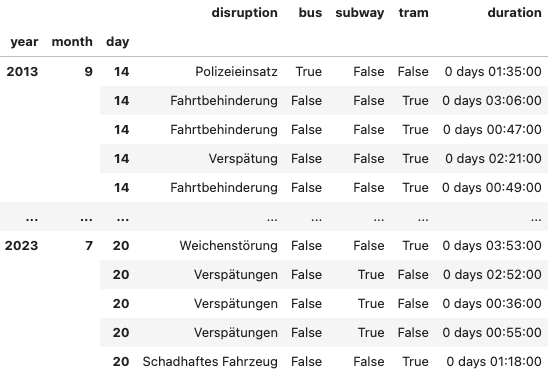

In [10]:

def load_traffic_data() -> pd.DataFrame:
    """ 
    Load the traffic data from the files into a pndas dataframe
    
    Returns
    --------
    traffic_data: data frame containing the traffic data
    """

    # YOUR CODE HERE

    traffic_data_path = os.path.join(data_path, 'traffic', 'traffic_disruptions.csv')
    traffic_data = pd.read_csv(traffic_data_path, sep=';')

    # Convert date columns to pandas datetime
    traffic_data['Start'] = pd.to_datetime(traffic_data['Start'], format='%d.%m.%Y %H:%M')
    traffic_data['Verkehrsaufnahme'] = pd.to_datetime(traffic_data['Verkehrsaufnahme'], format='%d.%m.%Y %H:%M')
    traffic_data['Ende'] = pd.to_datetime(traffic_data['Ende'], format='%d.%m.%Y %H:%M')

    # Extract year, month, and day
    traffic_data['year'] = traffic_data['Start'].dt.year
    traffic_data['month'] = traffic_data['Start'].dt.month
    traffic_data['day'] = traffic_data['Start'].dt.day

    # Create a MultiIndex
    traffic_data.set_index(['year', 'month', 'day'], inplace=True)

    # Create a disruption column
    traffic_data['disruption'] = traffic_data['Titel'].str.extract(r'\s(\w{4,}\b)', expand=False) 
    traffic_data['disruption'] = traffic_data['disruption'].str.replace(' Badner Bahn', '')

    # Create new columns bus, subway,tram
    traffic_data['bus'] = traffic_data['Linie(n)'].str.contains(r'\d{1,2}[AB]')
    traffic_data['subway'] = traffic_data['Linie(n)'].str.contains(r'U[1-6](?![Zz])')
    traffic_data['tram'] = traffic_data['Linie(n)'].str.contains(r'(D|O|U2[Zz]|VRT|WLB|Badner Bahn|((?![0-9]*[AB])^(?!U)[0-9]{1,2}))', regex=True)

    
    traffic_data['duration'] = traffic_data['Ende'] - traffic_data['Start']

    # Drop initial columns
    traffic_data = traffic_data.drop(columns=['Titel', 'Beschreibung', 'Start', 'Verkehrsaufnahme', 'Ende', 'Linie(n)'])

    # Remove rows with NaN and Test
    traffic_data = traffic_data.dropna()
    traffic_data = traffic_data[~traffic_data['disruption'].str.contains('Test')]

    return traffic_data

    

In [ ]:
''' Check the initial columns to drop after creating the required ones

def load_traffic_data() -> pd.DataFrame:
    traffic_data_path = os.path.join(data_path, 'traffic', 'traffic_disruptions.csv')
    traffic_data = pd.read_csv(traffic_data_path, sep=';')
    
    return traffic_data

traffic_data = load_traffic_data()
print(traffic_data.head())'''

In [11]:
# DO NOT MODIFY OR COPY THIS CELL!! 
data_traffic = load_traffic_data()
display(data_traffic)



/tmp/ipykernel_142/1868776789.py:35: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  traffic_data['tram'] = traffic_data['Linie(n)'].str.contains(r'(D|O|U2[Zz]|VRT|WLB|Badner Bahn|((?![0-9]*[AB])^(?!U)[0-9]{1,2}))', regex=True)


disruption    bus subway   tram        duration
year month day                                                       
2023 7     20        Schadhaftes   True  False  False 0 days 00:29:00
           20        Schadhaftes  False  False   True 0 days 01:20:00
           20     Verkehrsunfall  False  False   True 0 days 00:32:00
           20        Schadhaftes  False  False   True 0 days 01:10:00
           20     Verkehrsunfall  False  False   True 0 days 01:21:00
...                          ...    ...    ...    ...             ...
2013 9     14   Fahrtbehinderung  False  False   True 0 days 00:47:00
           14         Verspätung  False  False   True 0 days 02:21:00
           14   Fahrtbehinderung  False  False   True 0 days 00:49:00
           14   Fahrtbehinderung  False  False   True 0 days 01:34:00
           14        Schadhaftes  False  False   True 0 days 02:53:00

[94636 rows x 5 columns]

In [12]:
# use this cell to inspect the data.

print(f"Data dimensions are: {data_traffic.shape[0]} rows and {data_traffic.shape[1]} columns")
print(f"\nindex types are: \n-----------------\n{data_traffic.index.dtype}")
print(f"\ncolumn types are: \n-----------------\n{data_traffic.dtypes}")

Data dimensions are: 94636 rows and 5 columns

index types are: 
-----------------
object

column types are: 
-----------------
disruption             object
bus                    object
subway                 object
tram                   object
duration      timedelta64[ns]
dtype: object


#### Tests
Optional but recommended!
Check if the loading of the data was successful using some assertions.
The points will automatically be assigned by the hidden test, try to make sure that you covered all required points from above!

In [13]:
# use this cell to create your own tests
data_traffic['disruption'].unique()

array(['Schadhaftes', 'Verkehrsunfall', 'Weichenstörung', 'Verspätungen',
       'Betriebsstörung', 'Rettungseinsatz', 'Polizeieinsatz',
       'Verkehrsstörung', 'Falschparker', 'Fremder',
       'Fahrleitungsgebrechen', 'Verunreinigung', 'Gleisschaden',
       'Veranstaltung', 'Verkehrsbedingte', 'Feuerwehreinsatz',
       'Wasserrohrgebrechen', 'Stromstörung', 'Badner', 'Demonstration',
       'Stellwerkstörung', 'Signalstörung', 'Gleisbauarbeiten',
       'Bauarbeiten', 'Regenbogenparade', 'erhöhtes', 'Witterungsbedingt',
       'Sturmschaden', 'Gasrohrgebrechen', 'Staatsbesuch', 'Vienna',
       'Opernball', 'Betriebseinstellung', 'Erkrankung', 'Umleitung',
       'Fahrzeug', 'Verkehrsbedingt', 'Erhöhtes', 'Linien',
       'Fahrtbehinderung', 'Verspätung', 'Sachbeschädigung',
       'Wagengebrechen', 'Schadhafter'], dtype=object)

In [14]:
data_traffic.shape[0] - data_traffic.dropna().shape[0] == 0

True

In [15]:
# tests DO NOT MODIFY THIS CELL!!
# final dimensions should be like this:
assert data_traffic.shape == (94657, 5)

AssertionError: 

In [225]:
# hidden tests, DO NOT MODIFY OR COPY THIS CELL!! 

In [226]:
# hidden tests, DO NOT MODIFY OR COPY THIS CELL!! 


#### Question
Which combination of year+month+day shows the highest number of a given disruption? 
- Implement the function below to return the result!
- You should find the respective entry/entries using pandas!
- Return the first answer if there is more than one combination fulfilling these criteria.

In [16]:
def get_day_with_most_disruptions_by_type(data_frame:pd.DataFrame,
                                  disruption_type:str
                                 ) -> typing.Tuple[int,int,int]:
    # YOUR CODE HERE
    return data_frame.disruption.idxmax()
    
    #return year, month, day


In [17]:
# DO NOT MODIFY OR COPY THIS CELL!! 
year, month, day =get_day_with_most_disruptions_by_type(data_traffic, 'Schadhaftes Fahrzeug')
print(f"{day}.{month}.{year} has the highest number of malfunctioning vehicles!")

10.6.2023 has the highest number of malfunctioning vehicles!


In [18]:
# hidden tests, DO NOT MODIFY OR COPY THIS CELL!! 


## Task 2: Handling Missing Values (15 Points)

If you take a closer look at the data, you will notice that a few of the observations are missing.

There is a wide range of standard strategies to deal with such missing values, including:

- row deletion
- substitution methods (e.g., replace with mean or median)
- hot-/cold-deck methods (impute from a randomly selected similar record)
- regression methods

To decide which strategy is appropriate, it is essential to investigate the mechanism that led to the missing values to find out whether the missing data is missing completely at random, missing at random, or missing not at random. 

 - **MCAR** (Missing Completely At Random) means that there is no relationship between the missingness of the data and any of the values.
 - **MAR** (Missing At Random) means that there is a systematic relationship between the propensity of missing values and the observed data, but not the missing data.
 - **MNAR** (Missing Not At Random) means that there is a systematic relationship between the propensity of a value to be missing and its values. 
 

_______

You talked to the meteorologists who compiled the data to find out more about what mechanisms may have caused the missing values: 

1. They told you that they do not know why some of the temperature (`temp`) and pressure (`airPressure`) readings are missing. They suspect a problem with the IT infrastructure. In any case, the propensity of temperature and pressure values to be missing does not have anything to do with the weather itself.

2. For wind intensity values of 0, the wind direction is not provided (for obvious reasons). 

Check the plausibility of these hypotheses in the data, consider the implications, and devise appropriate strategies to deal with the various missing values.

- Handle missing values for the following columns: `temp`, `airPressure`, `windDir`

To implement your strategy, you can use a range of standard mechanisms provided by Pandas.

#### Visualize some data
Plot temperature (temp) and air pressure (airPressure) as a function of time for the weather data.
Additionally plot the average monthly sky coverage over all years.

In [19]:
display(weather_data)

date  airPressure  skyCover  temp  hum windDir  \
year month day hour                                                        
2009 1     1   7    2009-01-01        999.7        10  -4.5   79       W   
               14   2009-01-01        998.8         5  -0.1   71      NW   
               19   2009-01-01       1000.7        10  -1.8   72      NW   
           2   7    2009-01-02        999.6        10  -3.0   67     NaN   
               14   2009-01-02        998.5         9  -1.3   66       W   
...                        ...          ...       ...   ...  ...     ...   
2021 12    30  14   2021-12-30        993.3         8   9.5   88       E   
               19   2021-12-30        995.1         9   7.2   97      NE   
           31  7    2021-12-31        996.8         3  12.9   77       W   
               14   2021-12-31        996.2         3  15.9   62      NW   
               19   2021-12-31        994.6         3  13.3   72       W   

                     windBeauf  
year month day hour             
2009 1     1   7             2  
               14            2  
               19            2  
           2   7             0  
               14            2  
...                        ...  
2021 12    30  14            1  
               19            1  
           31  7             4  
               14            3  
               19            3  

[14244 rows x 7 columns]

Text(0.5, 1.0, 'Temperature as a Function of Time')

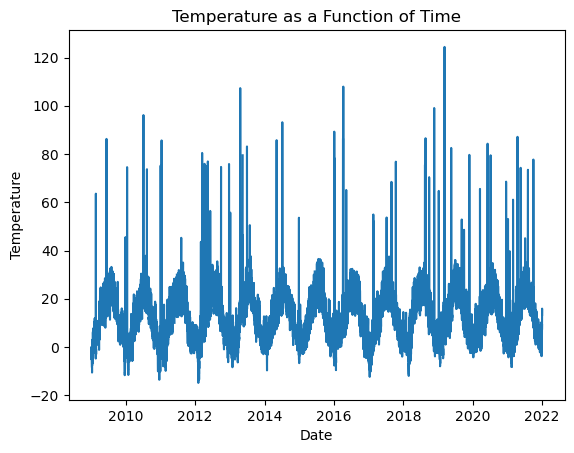

In [20]:
# plot the temperature 

# y=f(x), func of time is x-axis
temp = weather_data['temp']
date = weather_data['date']
plt.plot(date,temp)
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.title('Temperature as a Function of Time')


Text(0.5, 1.0, 'Air Pressure as a Function of Time')

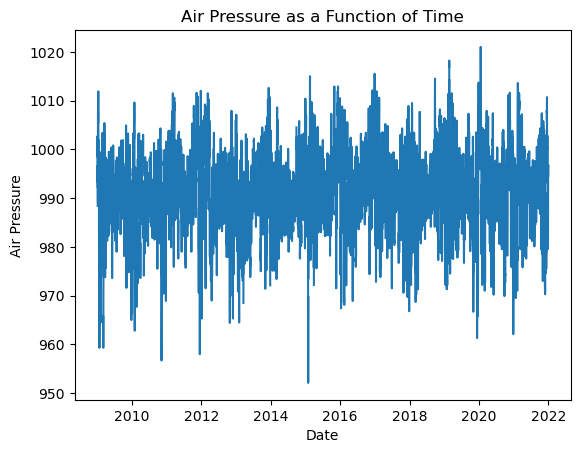

In [21]:
# plot the air pressure 

airPressure = weather_data['airPressure']
date = weather_data['date']
plt.plot(date,airPressure)
plt.xlabel('Date')
plt.ylabel('Air Pressure')
plt.title('Air Pressure as a Function of Time')

ValueError: x and y must have same first dimension, but have shapes (14244,) and (13,)

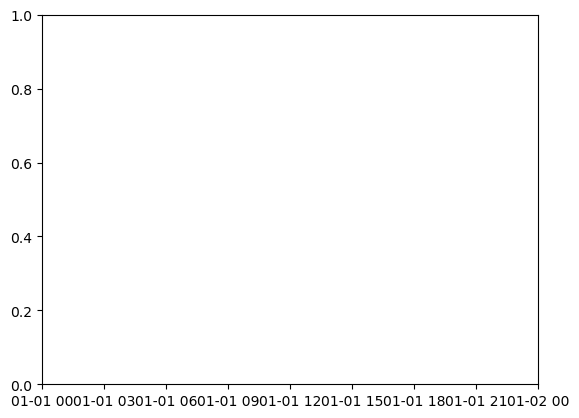

In [22]:
# plot the sky coverage 

# plot the average monthly sky coverage over all years.
# first groupby month, then get the mean
skyCover = weather_data.groupby('year')['skyCover'].mean()
date = weather_data['date']
plt.plot(date,skyCover)
plt.xlabel('Date')
plt.ylabel('Sky Coverage')
plt.title('Sky Coverage as a Function of Time')

### 2.1: Missing values for temperature and air pressure
Find and visualize missing values for `temp` and `airPressure` columns in the `weather_data` data frame.


#### Data inspection
First, let's visualize the missing data to get a better feel for what is happening.
- Implement the `get_data_around_missing` function below to extract and return a dataframe that only contains rows around missing (`isna`, `isnull`) values for the column indicated by `column`.
- First find missing values in the specified column
- For each missing value, create a dataframe that contain only rows with a date +- `delta_days` from the date of the missing value.
- Put the dataframes into `df_list` and return them.

In [23]:
from datetime import timedelta

def get_data_around_missing(df:pd.DataFrame, column:str, 
                            delta_days:int=2) -> typing.List[pd.DataFrame]:
    """ 
    Build a list of dataframes containing missing values indicated by column. 
    Each dataframe contains rows around a missing (isna)
    value in column, within a date of +- delta_days.

    Parameters
    --------
    df: dataframe containing the missing values
    column: the column to look for missing values
    delta_days: the number of days +-around the date of the missing values to keep in the returned data frames
    
    Returns
    --------
    df_list: list of dataframes with some missing data
    """
    # check out datetime.timedelta! 
    df_list = []

    # YOUR CODE HERE
    missing_values = df[df[column].isna()]
    for index, missing_row in missing_values.iterrows():
        missing_date = missing_row['date']
        start_date = missing_date - timedelta(days=delta_days)
        end_date = missing_date + timedelta(days=delta_days)
        data_around_missing = df[(df['date'] >= start_date) & (df['date'] <= end_date)]
        df_list.append(data_around_missing)        

    return df_list


In [24]:
# DO NOT MODIFY OR COPY THIS CELL!! 
missing_temp_df_list = get_data_around_missing(weather_data, 'temp')
missing_airPressure_df_list = get_data_around_missing(weather_data, 'airPressure')

In [25]:
# tests, DO NOT MODIFY OR COPY THIS CELL!! 
print(len(missing_temp_df_list))
print(len(missing_airPressure_df_list))

assert 150 < len(missing_temp_df_list) < 250, "There should be between 150 and 250 missing values in temp!"
assert 150 < len(missing_airPressure_df_list) < 250, "There should be between 150 and 250 missing values in airPressure!"

assert all([isinstance(cur_el, pd.DataFrame) for cur_el in missing_temp_df_list])
assert all([isinstance(cur_el, pd.DataFrame) for cur_el in missing_airPressure_df_list])

231
181


In [27]:
# hidden tests, DO NOT MODIFY OR COPY THIS CELL!! 

In order to be able to see the data, complete the function `plot_value_series` to plot a timeseries of a dataframe identified by `column`:


In [28]:
def plot_value_series(df:pd.DataFrame, column:str) -> None:
    """ 
    Plot the values in column in data frame df
    """
    # YOUR CODE HERE
    plt.plot(df['date'], df[column])
    plt.title(f'Time Series of {column}')
    plt.xlabel('Date')
    plt.ylabel(column)
    plt.show()


Now we use the function to plot a missing value for `temp` and `airPressure`:

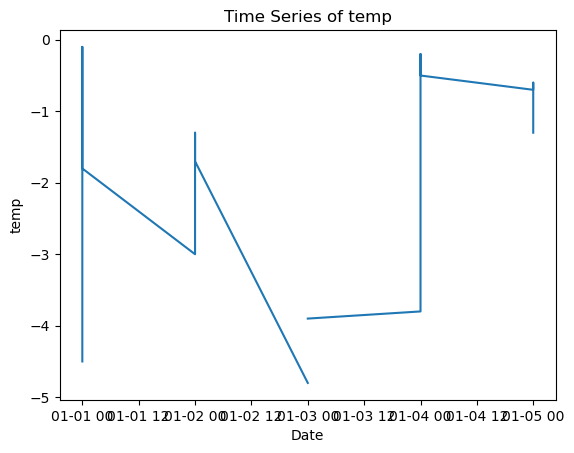

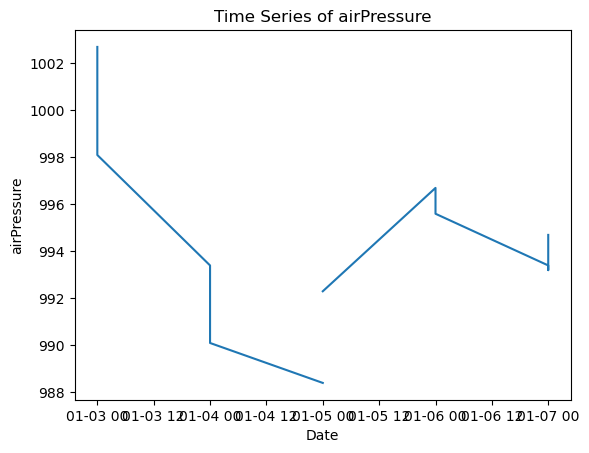

In [29]:
# tests,  DO NOT MODIFY OR COPY THIS CELL!! 
plot_value_series(missing_temp_df_list[0], 'temp')
plot_value_series(missing_airPressure_df_list[0], 'airPressure')

In [329]:
# hidden tests, DO NOT MODIFY OR COPY THIS CELL!! 

#### Handle missing temperature values
Use the plots above and the information that was given to us by the meterologist to decide on a suitable strategy to fix the missing values.

- Implement the function below to get rid of the missing values for temperature (`temp`).
- Choose an appropriate strategy to fill in the misssing values.

In [30]:
def handle_missing_temp_values(df:pd.DataFrame) -> pd.DataFrame:
    """ 
    Handle missing temperature values appropriately!

    Parameters
    --------
    df: dataframe containing the missing values
    
    Returns
    --------
    df_ret: dataframe with fixed values
    """
    df_ret = df.copy()

    # YOUR CODE HERE
    '''mean_temp = df_ret['temp'].mean()
    #df_ret['temp'].fillna(mean_temp, inplace=True)'''
    df_ret.temp = df_ret['temp'].interpolate()

    return df_ret

Plot the fixed stretch of temp values from above, and compare to the unmodified version:

In [31]:
missing_temp_idx = 0

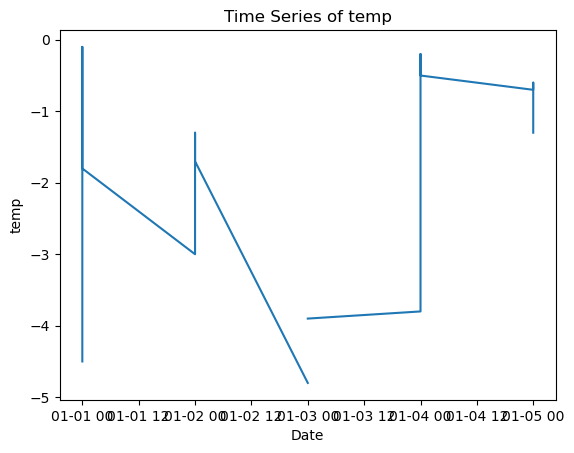

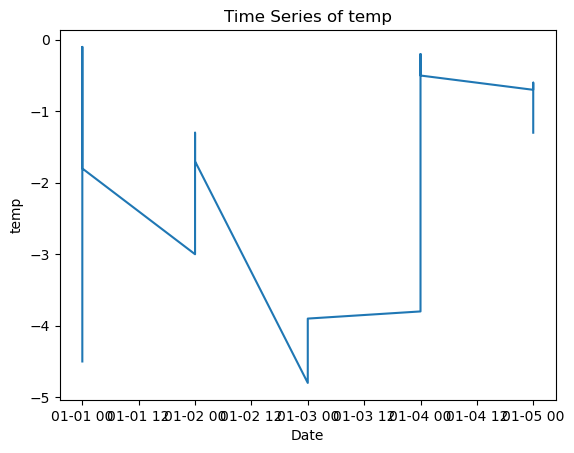

In [332]:
# DO NOT MODIFY OR COPY THIS CELL!! 
plot_value_series(missing_temp_df_list[missing_temp_idx], 'temp')
plot_value_series(handle_missing_temp_values(missing_temp_df_list[missing_temp_idx]), 'temp')

#### Handle missing air pressure values

Do the same for the air pressure values:

- Implement the function below to get rid of the missing values for air pressure (`airPressure`).
- Choose an appropriate strategy to fill in the misssing values.

In [32]:
def handle_missing_airPressure_values(df:pd.DataFrame) -> pd.DataFrame:
    """ 
    Handle missing air pressure values appropriately!

    Parameters
    --------
    df: dataframe containing the missing values
    
    Returns
    --------
    df_ret: dataframe with fixed values
    """
    df_ret = df.copy()

    # YOUR CODE HERE
    df_ret.airPressure = df_ret.airPressure.interpolate()
    '''mean_airPressure = df_ret['airPressure'].mean()
    #df_ret['airPressure'].fillna(mean_airPressure, inplace=True)'''

    return df_ret

Plot the fixed stretch of airPressure values from above:

In [33]:
missing_apr_idx = 0

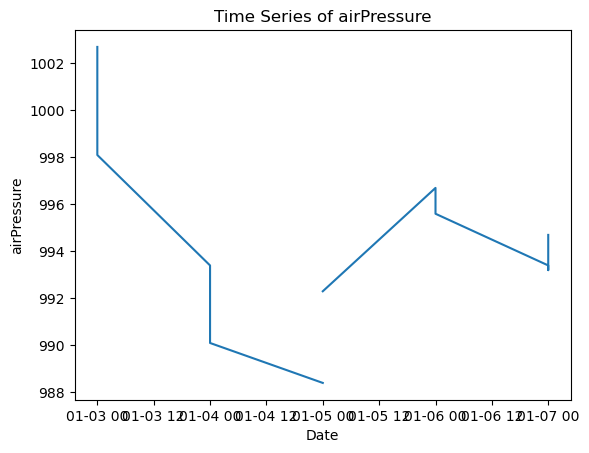

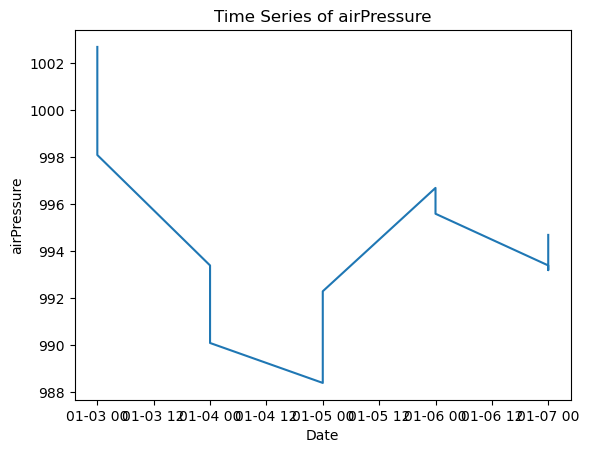

In [34]:
# DO NOT MODIFY OR COPY THIS CELL!! 
plot_value_series(missing_airPressure_df_list[missing_apr_idx], 'airPressure')
plot_value_series(handle_missing_airPressure_values(missing_airPressure_df_list[missing_apr_idx]), 'airPressure')

In [35]:
# tests, DO NOT MODIFY OR COPY THIS CELL!!
# the function to get the short dataframes around missing values should now return an empty list if we fix all temp values!
empty_temp_list = get_data_around_missing(handle_missing_temp_values(weather_data), 'temp')
empty_airPressure_list = get_data_around_missing(handle_missing_airPressure_values(weather_data), 'airPressure')
assert len(empty_temp_list) == 0
assert len(empty_airPressure_list) == 0

In [337]:
# hidden tests, DO NOT MODIFY OR COPY THIS CELL!!

### 2.2 Missing wind direction values

#### Data inspection
Check the assumption for missing wind direction values and handle the missing wind direction values in an appropriate way.

In [36]:
# write some code to check the assumtion for missing values of windDir

# YOUR CODE HERE
assert weather_data[weather_data['windBeauf'] == 0]['windDir'].isna().all()

In [37]:
display(weather_data)

date  airPressure  skyCover  temp  hum windDir  \
year month day hour                                                        
2009 1     1   7    2009-01-01        999.7        10  -4.5   79       W   
               14   2009-01-01        998.8         5  -0.1   71      NW   
               19   2009-01-01       1000.7        10  -1.8   72      NW   
           2   7    2009-01-02        999.6        10  -3.0   67     NaN   
               14   2009-01-02        998.5         9  -1.3   66       W   
...                        ...          ...       ...   ...  ...     ...   
2021 12    30  14   2021-12-30        993.3         8   9.5   88       E   
               19   2021-12-30        995.1         9   7.2   97      NE   
           31  7    2021-12-31        996.8         3  12.9   77       W   
               14   2021-12-31        996.2         3  15.9   62      NW   
               19   2021-12-31        994.6         3  13.3   72       W   

                     windBeauf  
year month day hour             
2009 1     1   7             2  
               14            2  
               19            2  
           2   7             0  
               14            2  
...                        ...  
2021 12    30  14            1  
               19            1  
           31  7             4  
               14            3  
               19            3  

[14244 rows x 7 columns]

#### Handle missing wind direction values
Implement a function that fixes the missing wind direction values.

In [38]:
def handle_missing_windDir_values(df:pd.DataFrame) -> pd.DataFrame:
    df_ret = df.copy()

    # YOUR CODE HERE
    df_ret['windDir'] = df_ret['windDir'].fillna('N/A')

    return df_ret

In [39]:
# tests, DO NOT MODIFY OR COPY THIS CELL!!
# Apply the windDir fix and check if any missing values remain
fix_wind_dir = handle_missing_windDir_values(weather_data)
assert fix_wind_dir[fix_wind_dir['windDir'].isnull()].empty

In [342]:
# hidden tests, DO NOT MODIFY OR COPY THIS CELL!!

### 2.3 Combine all fixes to get clean data

In [40]:
def handle_missing_values_weather(data:pd.DataFrame) -> pd.DataFrame:
    """ 
    Parameters
    --------
    data: data frame containing missing values 
    
    Returns
    --------
    data: data frame not containing any missing values
    """

    # YOUR CODE HERE
    return handle_missing_temp_values(handle_missing_airPressure_values(handle_missing_windDir_values(data)))
    

In [41]:
# DO NOT MODIFY OR COPY THIS CELL!!
weather_data_complete = handle_missing_values_weather(weather_data)

In [42]:
print(f"Before: \n---------\n{weather_data.isna().sum()}")
print(f"\nAfter: \n---------\n{weather_data_complete.isna().sum()}")

Before: 
---------
date             0
airPressure    181
skyCover         0
temp           231
hum              0
windDir        184
windBeauf        0
dtype: int64

After: 
---------
date           0
airPressure    0
skyCover       0
temp           0
hum            0
windDir        0
windBeauf      0
dtype: int64


In [43]:
# tests, DO NOT MODIFY OR COPY THIS CELL!!
# check if missing values are no longer present
assert not weather_data_complete.isna().any().any()
assert weather_data_complete.shape[0] == weather_data.shape[0]
assert weather_data_complete.shape[1] == weather_data.shape[1]

## Discussion

Write down what strategy you chose to fix the missing values for each variable and motivate why you decided for the strategies:

YOUR ANSWER HERE

For temperature (temp) and pressure (airPressure), the values are missing due to an issue with the IT infrastructure. This means that the weather values for temp and airPressure were definitely recorded. Therefore aggregating the missing values with the mean value of the existing data would make sense. Using mean would ensure that fixing the missing values with fillna captures the distribution of the values in the dataset. However, I decided to interpolate instead since it makes sense to take an estimation of values of the data points bordering the missing value. Since the missing values are related to weather, an approximation is the best alternative as it ensures that the fix corresponds to an estimate of unknown data points which is between two known data points.

For windDir, I found that the assumption that wind intensity values of 0, the wind direction is not provided was correct. I decided to fill the missing values with N/A as it would make it clear.




## Task 3: Handling Outliers (10 Points)

Additionally to the missing values, the dataset also seems to have some strange values, that are probably outliers. 
When confronted with the data, the meterologist gave you a bit more information:


1. Sometimes the temperture readings seem to be off, without any good reason.

2. In the timespan from early October 2015 until mid March 2016, the wind sensor was defective: it might have displayed wrong values for winds from SE direction.

3. In the `daily_weather_data`, the precipitation column contains some non-numeric values.

4. The precipitation sensor usually produces wrong values when hail is involved.






### 3.1 Temperature outliers
First we want to take a closer look at the temperature values. Check if we can identify some obvious outliers and come up with a strategy to handle/fix them.

In order to do so you will have to:
- Plot the temperature curve over time and a histogram of temperature values to identify possible outliers
- Plot a zoomed in version of individual outliers to get a better understanding what's happening
- Devise a strategy to get rid of outliers

#### Investigation
Implement the function below to create a plot of the temperature values (`temp`) over time. Additionally create a histogram with reasonable bins to identify the outliers:

In [44]:
def plot_temp_analysis(df: pd.DataFrame) -> None:
    """
    Create two plots:
    1) Temperature values over time for the whole dataframe
    2) A histogram for temperature values. 
       Choose appropriate bins enabling you to identify outliers!

    Parameters
    --------
    df: data frame containint the temperature values (temp) with potential outlier
    
    """

    # YOUR CODE HERE
    #raise NotImplementedError()
    plt.plot(df.date, df.temp)
    plt.xlabel("Date")
    plt.ylabel("Temeperature")
    plt.show()

    plt.hist(df.temp, bins=[-30,-20, -10, 0, 10, 20, 30, 40, 50, 60, 150])
    plt.xlabel("Temperature")
    plt.ylabel("No. of occurences")
    plt.show()


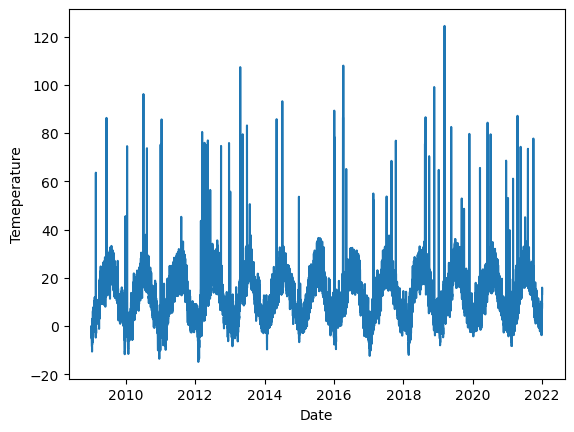

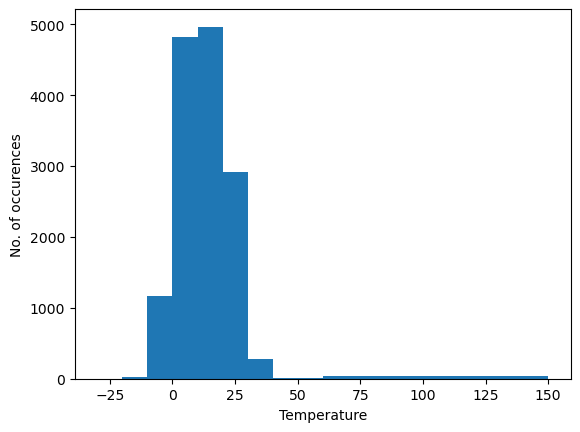

In [45]:
# DO NOT MODIFY OR COPY THIS CELL!!
plot_temp_analysis(weather_data_complete)

In [46]:
# hidden test, DO NOT MODIFY OR COPY THIS CELL!!

In the next cell, select a random outlier (e.g. the first) and plot the temperature curve around the outlier.

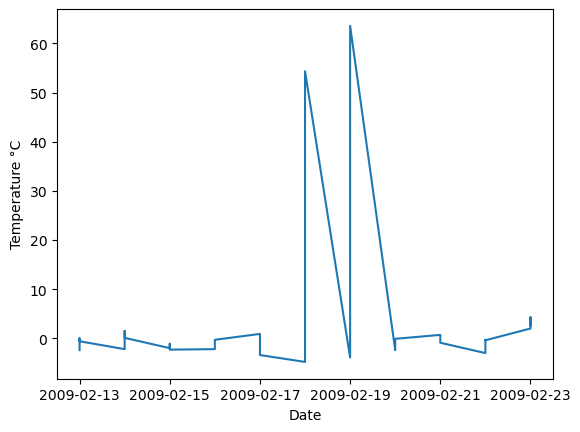

In [47]:
# YOUR CODE HERE
#raise NotImplementedError()

# Filter data for the first temperature outlier
first_outlier_date = weather_data_complete[weather_data_complete['temp'] >= 50].iloc[0]['date']

# Filter data for dates within 5 days of the first outlier
around_first_outlier_df = weather_data_complete[
    abs((weather_data_complete['date'] - first_outlier_date).dt.days) <= 5
]

plt.plot(around_first_outlier_df['date'], around_first_outlier_df['temp'])
plt.xlabel("Date")
plt.ylabel("Temperature °C")
plt.show()


In [48]:
# hidden test, DO NOT MODIFY OR COPY THIS CELL!!

#### Remove temperature outliers
Implement the below function using the strategy you defined above to get rid of the temperature outliers

In [49]:
def handle_temp_outliers(noisy_data) -> pd.DataFrame:
    """
    Parameters
    --------
    noisy_data: data frame that contains temperature outliers ('temp' column)

    Returns
    --------
    cleaned_data: data frame with temperature outliers removed/handled
    """
    cleaned_data = noisy_data.copy()

    # YOUR CODE HERE
    cleaned_data['temp'] = np.where(cleaned_data['temp'] < 50, cleaned_data['temp'], np.nan)
    cleaned_data['temp'].interpolate(inplace=True)

    return cleaned_data

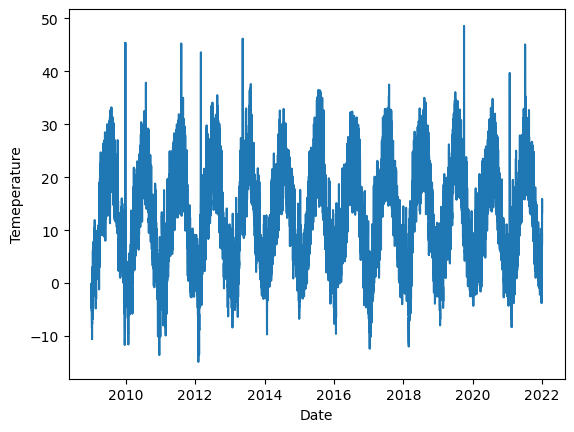

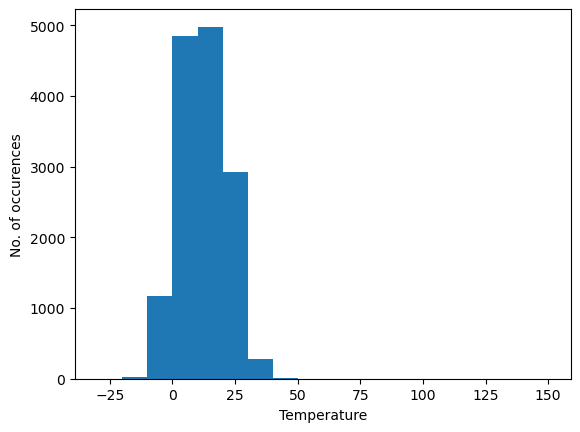

count    14244.000000
mean        12.304869
std          9.075515
min        -14.900000
25%          5.100000
50%         12.100000
75%         19.300000
max         48.582150
Name: temp, dtype: float64


In [50]:
# DO NOT MODIFY OR COPY THIS CELL!!
weather_data_cleaned = handle_temp_outliers(weather_data_complete)
plot_temp_analysis(weather_data_cleaned)
print(weather_data_cleaned['temp'].describe())

In [51]:
# test, DO NOT MODIFY OR COPY THIS CELL!!

# check if new missing values were introduced
assert not weather_data_cleaned.isna().any().any()
# check if outliers were simply dropped
assert weather_data_cleaned.shape == weather_data_complete.shape

In [52]:
# hidden test, DO NOT MODIFY OR COPY THIS CELL!!

In [53]:
# hidden test, DO NOT MODIFY OR COPY THIS CELL!!

### 3.2 Wind speed outliers

The second outlier problem was, that in the timespan from early October 2015 until mid March 2016, the wind sensor was defective: it might have displayed wrong values for winds from SE direction.

Double check if this is true, and if it is, fix the values appropriately.

#### Data inspection

Implement the function below to visualize the problematic wind sensor data.
Complete the function below to check the assumptions for wrong values of windBeauf.
- Plot the wind speed data over the questionable time duration (early October 2015 until mid March 2016)
- Plot a histogram of the windspeed values to identify outliers
- Check if the assumption regarding the wind direction is true (errors only from SE direction)

Bonus:
- Find out when exactly the sensor started to produce wrong values and when the sensor was fixed!

In [54]:
def analyze_wind_range(df:pd.DataFrame) -> typing.Tuple[int, typing.List[str]]:
    """
    Plot analysis plots for the wind data. Print outputs about relevant data 
    and return the relevant values as indicated.

    Parameters
    --------
    noisy_data: data frame that contains outliers
    
    Returns
    --------
    wind_dir_outliers: list of wind direction string code, for which outliers where found
    num_outliers: number of found outliers

    """

    #num_outliers = 0  # return a value that reflects how many outliers you identified
   # wind_dir_outliers = [] # a list of the string codes for wind directions where you identified outliers from


    # YOUR CODE HERE

    # Filter the data for the specified date range
    start_date = pd.Timestamp("2015-09-15")
    end_date = pd.Timestamp("2016-03-31")
    filtered_data = df[(df['date'] >= start_date) & (df['date'] <= end_date)]

    # Plot the windspeed over time
    plt.figure(figsize=(12, 6))
    plt.subplot(121)
    plt.plot(filtered_data['date'], filtered_data['windBeauf'])
    plt.title("Windspeed from Sep 2015 to March 2016")
    plt.xlabel("Date")
    plt.ylabel("Windspeed")

    # Plot a histogram of windspeed
    plt.subplot(122)
    plt.hist(filtered_data['windBeauf'], bins=12)
    plt.xlabel("Windspeed")
    plt.ylabel("No of Occurrences")

    plt.tight_layout()
    plt.show()

    # Find wind speed outliers
    wind_speed_outliers = filtered_data[filtered_data['windBeauf'] >= 8.5]

  
    outliers_in_direction_se = wind_speed_outliers[wind_speed_outliers['windDir'] == "SE"]
    outliers_not_in_direction_se = wind_speed_outliers[wind_speed_outliers['windDir'] != "SE"]

    
    # Check the assumption errors only from SE direction

    plt.bar(["Outliers in SE", "Outliers not in SE"], 
        [len(outliers_in_direction_se), len(outliers_not_in_direction_se)])
    plt.ylabel("No of Outliers")
    plt.show()

    num_outliers = len(wind_speed_outliers)
    wind_dir_outliers = wind_speed_outliers['windDir'].tolist()
    print(f"No. of outliers is: {num_outliers}")


    return wind_dir_outliers, num_outliers




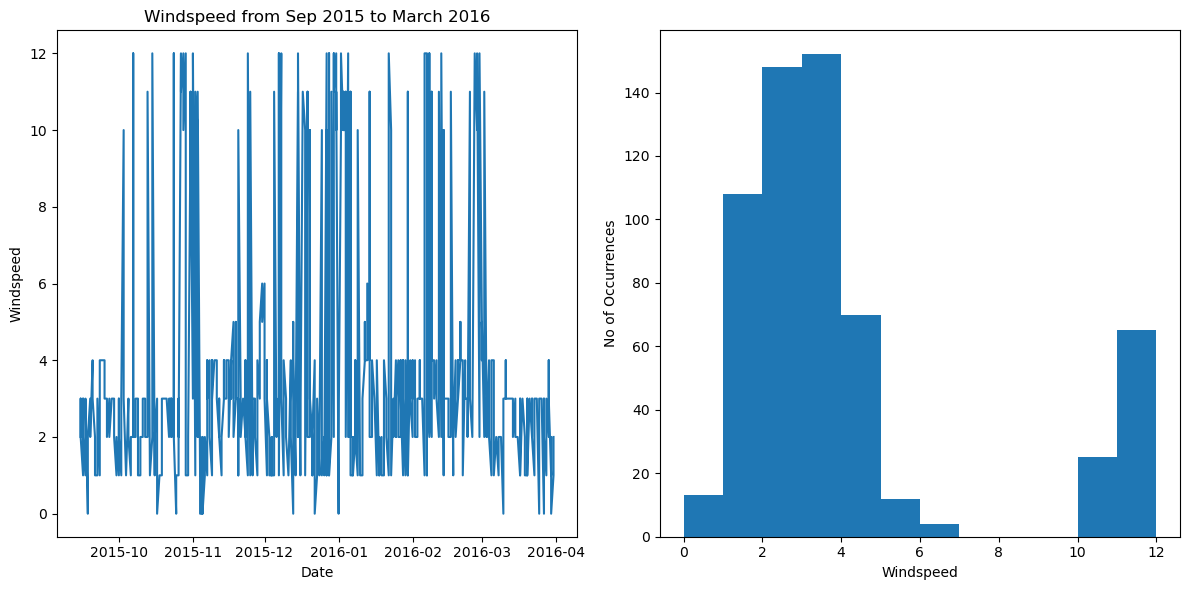

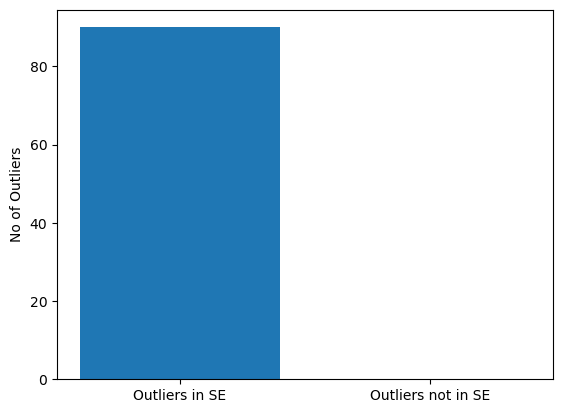

No. of outliers is: 90


In [55]:
# DO NOT MODIFY OR COPY THIS CELL!!
wind_dir_outliers, num_outliers = analyze_wind_range(weather_data_complete)

In [56]:
assert 0 < num_outliers < 500, "there should be more than zero but less than 500 outliers!"
assert len(wind_dir_outliers) > 0, "there should be at least one wind direction!"
assert isinstance(wind_dir_outliers[0], str), "the wind direction codes are strings with two characters!"
assert len(wind_dir_outliers[0]) == 2, "the wind direction codes are strings with two characters!"

# hidden test, DO NOT MODIFY OR COPY THIS CELL!!

In [67]:
wind_error_start_time = datetime.datetime(2015, 10, 15)

#### Fix wind sensor outliers
Fix the values appropriately. Implement a function that compensates for the problem you found.

In [68]:
def fix_windBeauf_values(df:pd.DataFrame) -> pd.DataFrame:
    """
    Parameters
    --------
    df: data frame that contains potential faulty wind values

    Returns
    -------
    df_ret: data frame with fixed wind values
    """

    df_ret = df.copy()

    # YOUR CODE HERE
    df_ret['windBeauf'] = df_ret.apply(lambda row: np.NaN 
                                       if (row['windDir'] == 'SE' and row['windBeauf'] >= 8.5) 
                                       else row['windBeauf'], axis=1)
        
    df_ret.windBeauf = df_ret.windBeauf.interpolate().astype(int)
    
    return df_ret


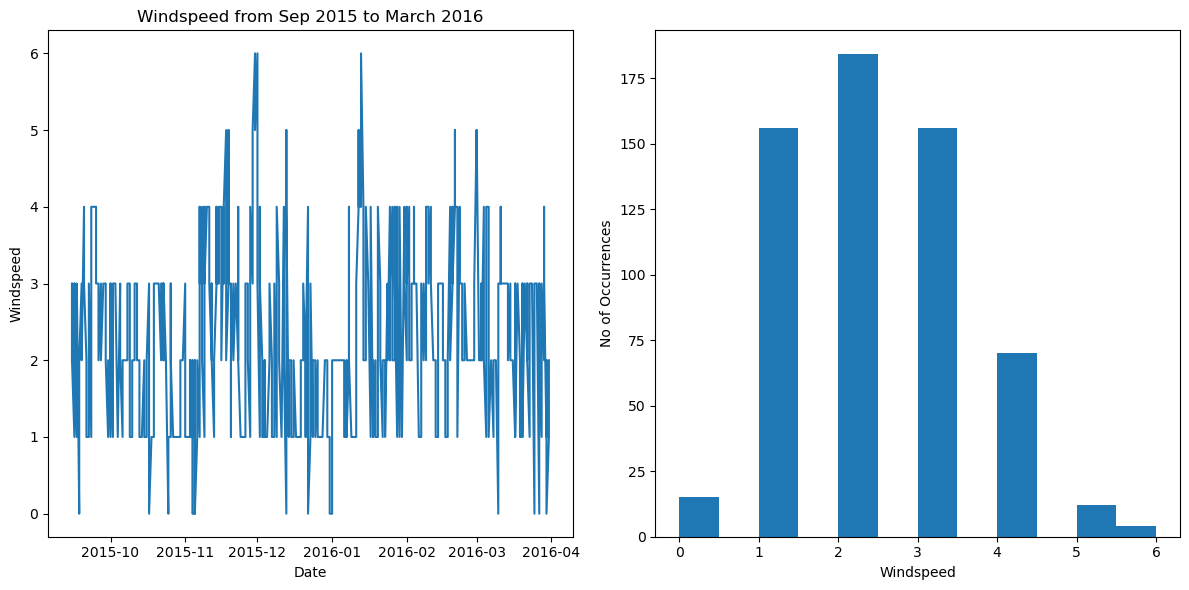

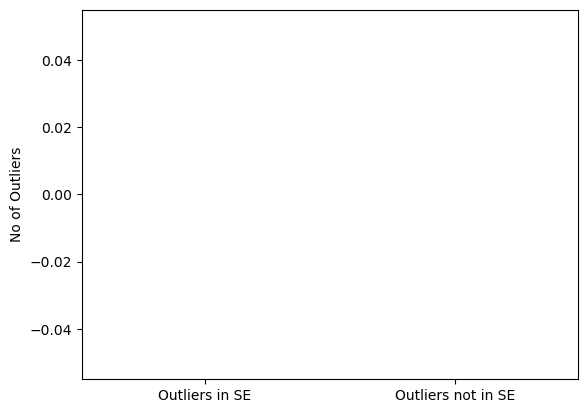

No. of outliers is: 0


In [69]:
# test, DO NOT MODIFY OR COPY THIS CELL!!
weather_data_fix_wind = fix_windBeauf_values(weather_data_complete)
wind_dir_outliers_fixed, num_outliers_fixed = analyze_wind_range(weather_data_fix_wind)

In [70]:
# test, DO NOT MODIFY OR COPY THIS CELL!!
assert num_outliers_fixed == 0, "now no outliers should be found"
assert len(wind_dir_outliers_fixed) == 0, "now no outliers should be found, so no directions!"
assert weather_data_fix_wind.shape == weather_data_complete.shape

# hidden test, DO NOT MODIFY OR COPY THIS CELL!!

### 3.3 Daily weather data: precipitation

When loading the data, we separated the precipitation data into the `daily_weather_data` dataframe.
This dataframe also has an issues:

- The `precip` column contains some non-numeric values 

#### Data inspection
Check the occurance of the non-numeric values in the precipitation data. You can check the file `data/weather/description.txt`, which might have additional clues what is going on.

Implement the function below and return a list of the non-numeric values that occur in the `precip` column of `daily_weather_data`. Make sure to only return every unique value once! 

In [71]:
def get_non_numeric_precip_values(df:pd.DataFrame) -> typing.Set[str]:
    """
    Parameters
    --------
    df: data frame that contains non-numeric values in precip column

    Returns
    -------
    non_numeric_values: list of unique non-numeric values. 
    Do not return duplicate values in the list!
    """
    non_numeric_values = set()

    # YOUR CODE HERE
    precip_values = df['precip']

    non_numeric_values = set(value for value in precip_values if not (str(value).replace(".", "", 1).isdigit()))

    return non_numeric_values

In [72]:
# DO NOT MODIFY OR COPY THIS CELL!!
non_numeric_values = get_non_numeric_precip_values(daily_weather_data)
print(f"\nnon-numeric values values: {non_numeric_values}")


non-numeric values values: {'traces'}


In [73]:
# tests, DO NOT MODIFY OR COPY THIS CELL!!
assert isinstance(non_numeric_values, set) , "make sure to return a set, so no duplicate values can be returned!!"
assert len(non_numeric_values) > 0, "there should be some non-numeric values in daily_weather_data!"
assert isinstance(list(non_numeric_values)[0], str), "only return the non-numeric values as strings!"

#### Fix non-numeric values
Replace non-numeric values with some appropriate numerical values and convert the column to a more suitable data type.
To get an idea, what appropriate values might be, check the file `data/weather/description.txt` and the other numeric values in the `precip` column.

In [74]:
def fix_precip_values(df:pd.DataFrame) -> pd.DataFrame:
    """
    Parameters
    --------
    df: data frame that contains non-numeric values in precip column

    Returns
    -------
    ret_df: data frame with fixed precip values
    """
    ret_df = df.copy()

    # YOUR CODE HERE
    ret_df['precip'] = ret_df['precip'].replace("traces", 0).astype(float)

    return ret_df

In [75]:
# DO NOT MODIFY OR COPY THIS CELL!!
daily_weather_data_fixed_precip = fix_precip_values(daily_weather_data)

In [76]:
# test, DO NOT MODIFY OR COPY THIS CELL!!
assert pd.api.types.is_float_dtype(daily_weather_data_fixed_precip['precip'].dtype), "precip should now be a float column!!"
assert daily_weather_data_fixed_precip.shape == daily_weather_data.shape, "do not remove or add rows!"

### Combining the fixes

In [77]:
# DO NOT MODIFY OR COPY THIS CELL!!
def fix_values_daily(data):
    """ 
    Parameters
    --------
    data: data frame containing missing values 
    
    Returns
    --------
    complete_data: data frame not containing any missing values
    """
    complete_data = data.copy()
    complete_data = fix_precip_values(complete_data)
    
    return complete_data

   
def handle_outliers(data):
    """ 
    Parameters
    --------
    data: data frame containing outlier values 
    
    Returns
    --------
    complete_data: data frame not containing any outlier values
    """
    complete_data = data.copy()
    complete_data = handle_temp_outliers(complete_data)
    complete_data = fix_windBeauf_values(complete_data)
    
    return complete_data

In [78]:
# DO NOT MODIFY OR COPY THIS CELL!!
daily_weather_data_finished = fix_values_daily(daily_weather_data)
weather_data_finished = handle_outliers(weather_data_complete)

In [79]:
weather_data_complete

date  airPressure  skyCover  temp  hum windDir  \
year month day hour                                                        
2009 1     1   7    2009-01-01        999.7        10  -4.5   79       W   
               14   2009-01-01        998.8         5  -0.1   71      NW   
               19   2009-01-01       1000.7        10  -1.8   72      NW   
           2   7    2009-01-02        999.6        10  -3.0   67     N/A   
               14   2009-01-02        998.5         9  -1.3   66       W   
...                        ...          ...       ...   ...  ...     ...   
2021 12    30  14   2021-12-30        993.3         8   9.5   88       E   
               19   2021-12-30        995.1         9   7.2   97      NE   
           31  7    2021-12-31        996.8         3  12.9   77       W   
               14   2021-12-31        996.2         3  15.9   62      NW   
               19   2021-12-31        994.6         3  13.3   72       W   

                     windBeauf  
year month day hour             
2009 1     1   7             2  
               14            2  
               19            2  
           2   7             0  
               14            2  
...                        ...  
2021 12    30  14            1  
               19            1  
           31  7             4  
               14            3  
               19            3  

[14244 rows x 7 columns]

## Discussion

Express your findings and define a strategy to get rid of the outliers:

YOUR ANSWER HERE

The temperature seems to be normal to upto about 40 degrees
The outliers can be seen from temperatures about above 60 to 150 degrees. The strategy used to fux the outliers is to approximate the temperatures sorrounding the outliers through interpolations

The strategy used to fix the wind speed outliers was to first set the outliers to NaN. I then filled in the NaN values with an estimate of wind speeds adjacent to the outliers

The strategy used to fix the 'precip' column, which contain non-numeric values("traces") is to replace these non-numeric values with a numeric equivalent. In this case, "traces" is replaced with 0.





## Task 4: Aggregate values (5 Points)

Aggregate the observations on a daily basis. Return a data frame with a hierarchical index (levels `year`, `month` and `day`) and the following daily aggregations as columns:

- `temp_dailyMin`: minimum of `temp`
- `temp_dailyMax`: max of `temp`
- `temp_dailyMean`: mean of `temp`
- `temp_dailyMedian`: median of `temp`

- `hum_dailyMin`: min of `hum`
- `hum_dailyMax`: max of `hum`
- `hum_dailyMean`: mean of `hum`

- `wind_dailyMean`: mean of `windBeauf`
- `wind_dailyMax`: max of `windBeauf`
- `wind_dailyMin`: min of `windBeauf`

Additionally merge the precipitation values from the `daily_weather_data` dataframe also into the newly created dataframe and aggregate them into the folling cprecipp_wvaluelyMin`: min of `precip`



In [80]:
def aggregate_daily(hourly_data, daily_data):
    # YOUR CODE HERE
    daily_weather_data = pd.DataFrame()
    grouped_hourly_df = hourly_data.copy().groupby(level=[0, 2]).agg(
        temp_dailyMin = ("temp", min),
        temp_dailyMax = ("temp", max),
        temp_dailyMean = ("temp", np.mean),
        temp_dailyMedian = ("temp", np.median),
        hum_dailyMin = ("hum", min),
        hum_dailyMax = ("hum", max),
        hum_dailyMean = ("hum", np.mean),
        wind_dailyMean = ("windBeauf", np.mean),
        wind_dailyMax = ("windBeauf", max),
        wind_dailyMin = ("windBeauf", min)
    )
            
    grouped_daily_df = daily_data.copy().groupby(level=[0, 2]).agg(
        precip_dailyMin = ("precip", min)
    )
    
    return grouped_hourly_df.join(grouped_daily_df)

    

In [81]:
agg_daily_data = aggregate_weekly(weather_data_finished, daily_weather_data_finished)

len(agg_daily_data.columns)

NameError: name 'aggregate_weekly' is not defined

In [82]:
agg_daily_data = aggregate_daily(weather_data_finished, daily_weather_data_finished)

len(agg_daily_data.columns)

/tmp/ipykernel_142/1062979291.py:4: FutureWarning: The provided callable <built-in function min> is currently using SeriesGroupBy.min. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "min" instead.
  grouped_hourly_df = hourly_data.copy().groupby(level=[0, 2]).agg(
/tmp/ipykernel_142/1062979291.py:4: FutureWarning: The provided callable <built-in function max> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  grouped_hourly_df = hourly_data.copy().groupby(level=[0, 2]).agg(
/tmp/ipykernel_142/1062979291.py:4: FutureWarning: The provided callable <function mean at 0x7ff4b021d3f0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  grouped_hourly_df = hourly_data.copy().groupby(le

11

In [83]:
# DO NOT MODIFY OR COPY THIS CELL!!
agg_daily_data =  aggregate_daily(weather_data_finished, daily_weather_data_finished)
display(agg_daily_data)
assert len(agg_daily_data.columns) >= 11

/tmp/ipykernel_142/1062979291.py:4: FutureWarning: The provided callable <built-in function min> is currently using SeriesGroupBy.min. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "min" instead.
  grouped_hourly_df = hourly_data.copy().groupby(level=[0, 2]).agg(
/tmp/ipykernel_142/1062979291.py:4: FutureWarning: The provided callable <built-in function max> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  grouped_hourly_df = hourly_data.copy().groupby(level=[0, 2]).agg(
/tmp/ipykernel_142/1062979291.py:4: FutureWarning: The provided callable <function mean at 0x7ff4b021d3f0> is currently using SeriesGroupBy.mean. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "mean" instead.
  grouped_hourly_df = hourly_data.copy().groupby(le

temp_dailyMin  temp_dailyMax  temp_dailyMean  temp_dailyMedian  \
year day                                                                   
2009 1             -4.5           28.1       11.704167             12.60   
     2             -3.0           33.2       12.050000             12.20   
     3             -4.8           27.1       11.401389             13.00   
     4             -3.8           27.0       11.275000             11.45   
     5             -1.3           23.8       11.550000             12.35   
...                 ...            ...             ...               ...   
2021 27            -1.4           29.5       11.586111             12.30   
     28             0.2           31.6       12.179167             13.65   
     29             1.1           29.8       13.875758             14.40   
     30             0.2           30.3       13.737879             13.10   
     31            -1.4           26.4       13.866667             14.70   

          hum_dailyMin  hum_dailyMax  hum_dailyMean  wind_dailyMean  \
year day                                                              
2009 1              54            95      74.388889        2.388889   
     2              43            92      70.611111        2.277778   
     3              31            99      74.750000        2.111111   
     4              45            96      76.250000        2.500000   
     5              41            98      72.444444        2.444444   
...                ...           ...            ...             ...   
2021 27             37            97      67.888889        2.194444   
     28             33            97      68.361111        2.194444   
     29             32            97      65.939394        2.606061   
     30             23            98      66.393939        2.848485   
     31             37            91      64.190476        2.523810   

          wind_dailyMax  wind_dailyMin  precip_dailyMin  
year day                                                 
2009 1                4              0              0.0  
     2                4              0              0.0  
     3                4              1              0.0  
     4                5              1              0.0  
     5                4              1              0.0  
...                 ...            ...              ...  
2021 27               4              0              0.0  
     28               4              1              0.0  
     29               4              1              0.0  
     30               6              1              0.0  
     31               4              0              0.0  

[403 rows x 11 columns]

In [85]:
# tests, DO NOT MODIFY OR COPY THIS CELL!!
assert len(agg_daily_data.columns) >= 11, "according to the instructions, the dataframe should have >= 13 columns"
assert len(agg_daily_data.index.levels) == 3, "according to the instructions, the dataframe should have a multi-index with 2 levels"

AssertionError: according to the instructions, the dataframe should have a multi-index with 2 levels

In [86]:
# tests, DO NOT MODIFY OR COPY THIS CELL!!

#I think there might be an issue with the second assertion. Should it be 2 or 3 levels?
assert len(agg_daily_data.columns) >= 11, "according to the instructions, the dataframe should have >= 13 columns"
assert len(agg_daily_data.index.levels) == 2, "according to the instructions, the dataframe should have a multi-index with 2 levels"

In [101]:
#len(agg_daily_data.columns)
#len(agg_daily_data.index.levels)
#len(agg_daily_data)
#len(agg_daily_data.columns)
#len(agg_daily_data.index.levels)
#len(agg_daily_data.index.levels[0])
#len(agg_daily_data.index.levels[1])

31

In [394]:
# hidden tests, DO NOT MODIFY OR COPY THIS CELL!!

## Task 5: Merge Traffic and weather datasets (5 Points)

Merge the `agg_daily_data` and `data_traffic` datasets.
Both dataframes should now be on a daily index. 
Beware that both datasets contain rows that do not appear in the other dataset.

In [102]:
# tests, DO NOT MODIFY OR COPY THIS CELL!!
# Neither of the tables contain missing data

print(f"traffic data, missing data (should be 0): \n{data_traffic.isna().sum()}")
print(f"weather data, missing data (should be 0): \n{agg_daily_data.isna().sum()}")

assert not data_traffic.isna().any().any(), "we should have eliminated all missing values!!"
assert not agg_daily_data.isna().any().any(), "we should have eliminated all missing values!!"

traffic data, missing data (should be 0): 
disruption    0
bus           0
subway        0
tram          0
duration      0
dtype: int64
weather data, missing data (should be 0): 
temp_dailyMin       0
temp_dailyMax       0
temp_dailyMean      0
temp_dailyMedian    0
hum_dailyMin        0
hum_dailyMax        0
hum_dailyMean       0
wind_dailyMean      0
wind_dailyMax       0
wind_dailyMin       0
precip_dailyMin     0
dtype: int64


In [103]:
# use this cell for experimentation / analysis for merging data

# YOUR CODE HERE
display(data_traffic)

disruption    bus subway   tram        duration
year month day                                                       
2023 7     20        Schadhaftes   True  False  False 0 days 00:29:00
           20        Schadhaftes  False  False   True 0 days 01:20:00
           20     Verkehrsunfall  False  False   True 0 days 00:32:00
           20        Schadhaftes  False  False   True 0 days 01:10:00
           20     Verkehrsunfall  False  False   True 0 days 01:21:00
...                          ...    ...    ...    ...             ...
2013 9     14   Fahrtbehinderung  False  False   True 0 days 00:47:00
           14         Verspätung  False  False   True 0 days 02:21:00
           14   Fahrtbehinderung  False  False   True 0 days 00:49:00
           14   Fahrtbehinderung  False  False   True 0 days 01:34:00
           14        Schadhaftes  False  False   True 0 days 02:53:00

[94636 rows x 5 columns]

In [104]:
def merge_data(weather_df, traffic_df):
    """ 
    Parameters
    --------
    weather_df: daily weather data frame
    traffic_df: traffic data frame
    
    Returns
    --------
    merged_data: merged data frame that contains both daily weather observations and traffic incidents
    """
    # YOUR CODE HERE
    return weather_df.join(traffic_df)

    return merged_data

In [105]:
# DO NOT MODIFY OR COPY THIS CELL!!
data_merged = merge_data(agg_daily_data, data_traffic)
data_merged

temp_dailyMin  temp_dailyMax  temp_dailyMean  \
year day month                                                 
2009 1   NaN             -4.5           28.1       11.704167   
     2   NaN             -3.0           33.2       12.050000   
     3   NaN             -4.8           27.1       11.401389   
     4   NaN             -3.8           27.0       11.275000   
     5   NaN             -1.3           23.8       11.550000   
...                       ...            ...             ...   
2021 31  1               -1.4           26.4       13.866667   
         1               -1.4           26.4       13.866667   
         1               -1.4           26.4       13.866667   
         1               -1.4           26.4       13.866667   
         1               -1.4           26.4       13.866667   

                temp_dailyMedian  hum_dailyMin  hum_dailyMax  hum_dailyMean  \
year day month                                                                
2009 1   NaN               12.60            54            95      74.388889   
     2   NaN               12.20            43            92      70.611111   
     3   NaN               13.00            31            99      74.750000   
     4   NaN               11.45            45            96      76.250000   
     5   NaN               12.35            41            98      72.444444   
...                          ...           ...           ...            ...   
2021 31  1                 14.70            37            91      64.190476   
         1                 14.70            37            91      64.190476   
         1                 14.70            37            91      64.190476   
         1                 14.70            37            91      64.190476   
         1                 14.70            37            91      64.190476   

                wind_dailyMean  wind_dailyMax  wind_dailyMin  precip_dailyMin  \
year day month                                                                  
2009 1   NaN          2.388889              4              0              0.0   
     2   NaN          2.277778              4              0              0.0   
     3   NaN          2.111111              4              1              0.0   
     4   NaN          2.500000              5              1              0.0   
     5   NaN          2.444444              4              1              0.0   
...                        ...            ...            ...              ...   
2021 31  1            2.523810              4              0              0.0   
         1            2.523810              4              0              0.0   
         1            2.523810              4              0              0.0   
         1            2.523810              4              0              0.0   
         1            2.523810              4              0              0.0   

                      disruption    bus subway   tram        duration  
year day month                                                         
2009 1   NaN                 NaN    NaN    NaN    NaN             NaT  
     2   NaN                 NaN    NaN    NaN    NaN             NaT  
     3   NaN                 NaN    NaN    NaN    NaN             NaT  
     4   NaN                 NaN    NaN    NaN    NaN             NaT  
     5   NaN                 NaN    NaN    NaN    NaN             NaT  
...                          ...    ...    ...    ...             ...  
2021 31  1      Feuerwehreinsatz   True  False  False 0 days 00:41:00  
         1        Polizeieinsatz  False  False   True 0 days 00:34:00  
         1       Rettungseinsatz   True  False  False 0 days 00:18:00  
         1          Verspätungen  False   True  False 0 days 02:41:00  
         1       Rettungseinsatz   True  False  False 0 days 00:26:00  

[68773 rows x 16 columns]

In [106]:
# tests, DO NOT MODIFY OR COPY THIS CELL!!
print(data_merged.shape)
assert data_merged.shape[0] > 66000, "there should be more than 66.000 rows in the merged dataset"
assert data_merged.shape[1] >= 16, "5 column for traffic, 11 feature columns from weather data"


(68773, 16)


In [112]:
# tests, DO NOT MODIFY OR COPY THIS CELL!!
#print(data_merged.shape)
#assert data_merged.shape[0] > 66000, "there should be more than 66.000 rows in the merged dataset"
#assert data_merged.shape[1] >= 16, "5 column for traffic, 11 feature columns from weather data"

### BEGIN HIDDEN TESTS
#len(data_merged.index.levels) #== 3 # multi index correctly set
len(data_merged.index.levels[0]) #== 9 ## 9 years
len(data_merged.index.levels[1]) #== 12 ## 12 different months
### END HIDDEN TESTS

31

## Store processed data for Tasks 6-8

Here we export the prepared dataset for usage in the notebook B.
If you encounter problems with the first five tasks, you can load a pickled `DataFrame` containing already merged and preprocessed weather and traffic datasets. You can use this data to complete tasks 6-8 in notebook B. 

In [401]:
with open(os.path.join(os.environ["HOME"], "shared", "188.995-2023W", "data", "data_processed.pickle"),"wb") as fp:
    pickle.dump(data_merged, fp)  

PermissionError: [Errno 13] Permission denied: '/home/e12331442/shared/188.995-2023W/data/data_processed.pickle'